# Super computer Assisted edge detection and STEM EELS

In [1]:
%%time
%matplotlib widget
import matplotlib.pylab as plt
import numpy as np

import Pyro5.api
import io
import time


CPU times: user 478 ms, sys: 83.9 ms, total: 562 ms
Wall time: 1.1 s


In [2]:
# !pip install pyTEMlib

## set server

In [18]:
%%time
uri = "PYRO:array.server@10.46.217.242:9091"
array_server = Pyro5.api.Proxy(uri)

CPU times: user 211 µs, sys: 0 ns, total: 211 µs
Wall time: 218 µs


## acquire camera

CPU times: user 48 ms, sys: 9.18 ms, total: 57.2 ms
Wall time: 4.5 s


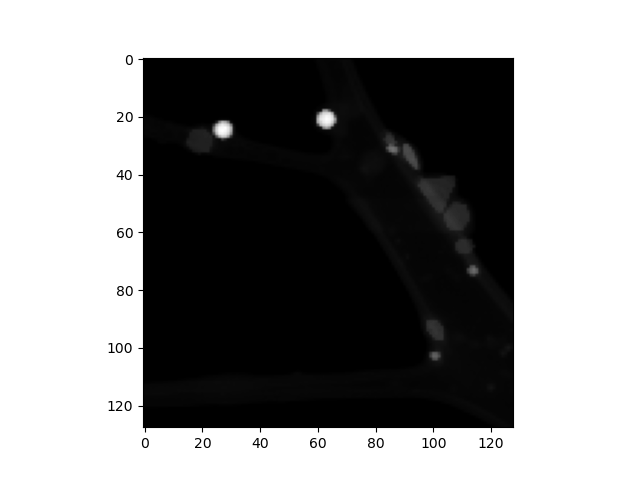

In [27]:
%%time
#Activate camera
array_server.activate_camera()
array_list, shape, dtype = array_server.get_ds(128, 128)
im_array = np.array(array_list, dtype=dtype).reshape(shape)
np.savez("survey_image_gold_ag.npz", img = im_array)
plt.figure()
im = plt.imshow(im_array, cmap="gray")
# plt.colorbar(im)
# plt.show()

## take eels

CPU times: user 27 ms, sys: 4.01 ms, total: 31 ms
Wall time: 7.01 s


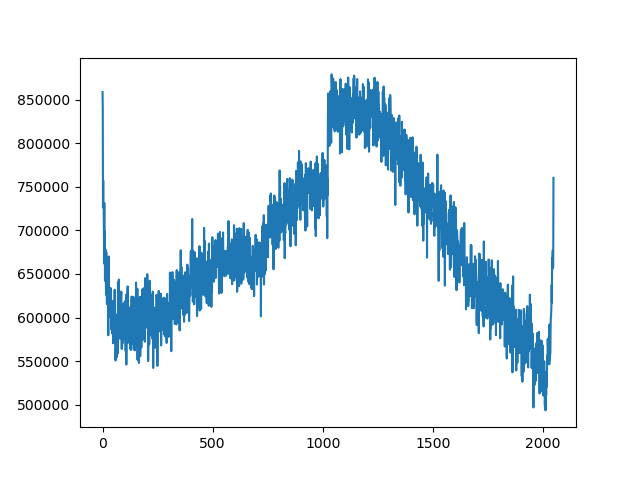

In [26]:
%%time
## dummy eels
array_server.acquire_camera(exposure = 1)
array_list, shape, dtype = array_server.get_eels()
array = np.array(array_list, dtype=dtype).reshape(shape)
np.savez("eels_.npz", spec = array)

plt.figure()
plt.plot(array)
# plt.ylim(0,1e6)

CPU times: user 30.3 ms, sys: 5.82 ms, total: 36.2 ms
Wall time: 33.6 s


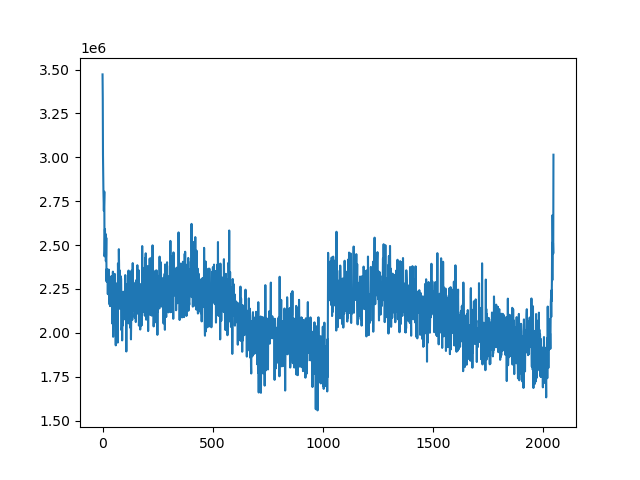

In [9]:
%%time
## dummy eels
array_server.acquire_camera(exposure = 1)
array_list, shape, dtype = array_server.get_eels()
array2 = np.array(array_list, dtype=dtype).reshape(shape)
np.savez("eels_nanowire5.npz", spec = array2)

plt.figure()
plt.plot(array)
# plt.ylim(0,1e6)

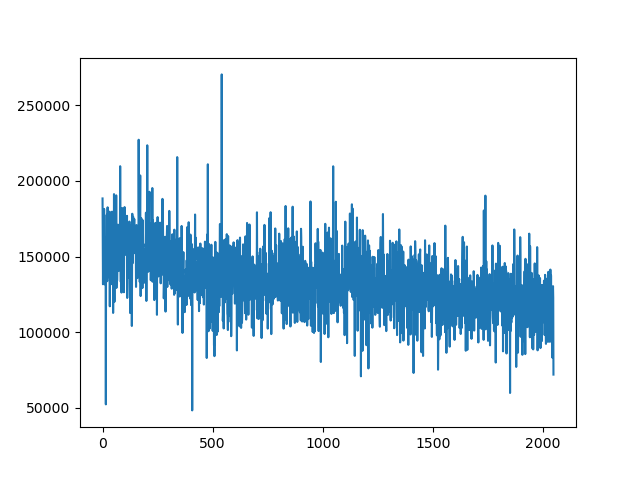

In [10]:
plt.figure()
plt.plot(array - array2)

In [31]:
x, y =  44, 101

/tmp/ipykernel_137714/1164380679.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


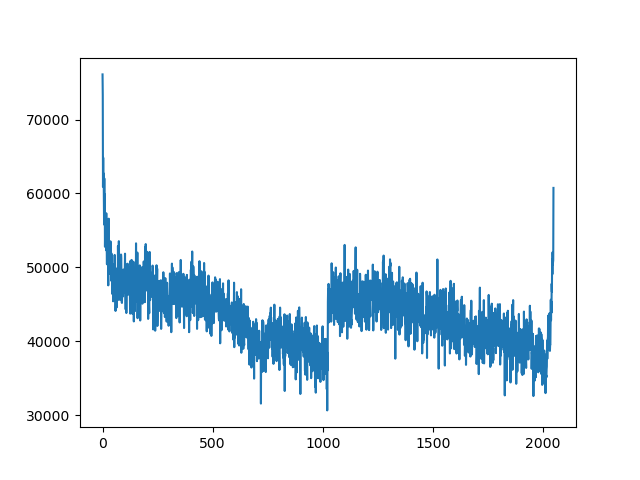

In [32]:
array_server.set_beam_pos(x, y)
array_server.acquire_camera(exposure=0.1)
array_list, shape, dtype = array_server.get_eels()
array = np.array(array_list, dtype=dtype).reshape(shape)
plt.figure()
plt.plot(array)

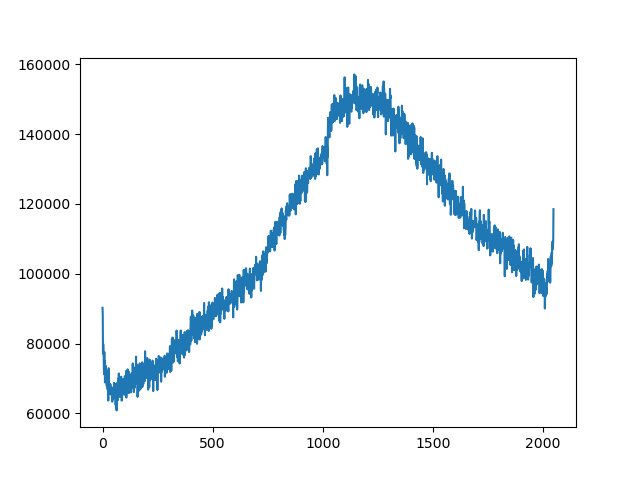

In [30]:
array_server.set_beam_pos(x, y)
array_server.acquire_camera(exposure=0.1)
array_list, shape, dtype = array_server.get_eels()
array = np.array(array_list, dtype=dtype).reshape(shape)
plt.figure()
plt.plot(array)

## detect edges : do eels on those coordinates

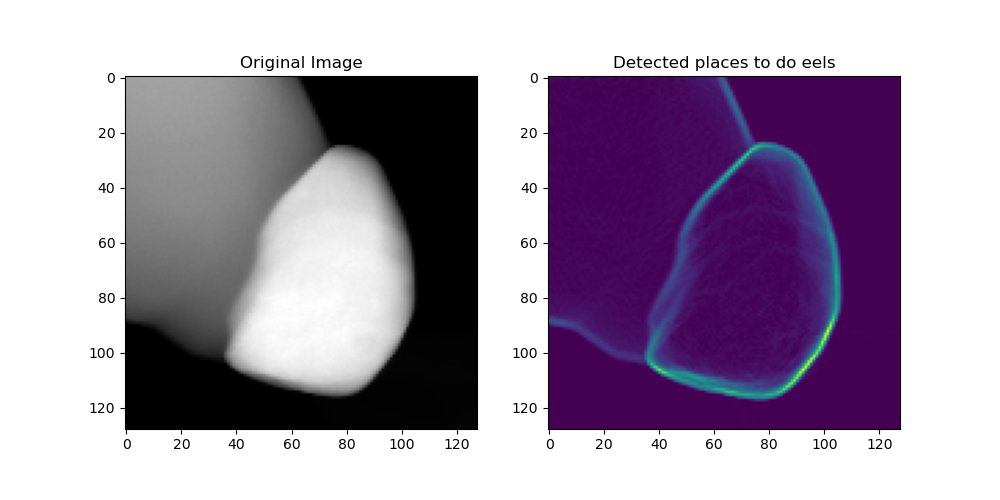

CPU times: user 141 ms, sys: 5.58 ms, total: 146 ms
Wall time: 143 ms


In [72]:
%%time
import numpy as np
import matplotlib.pyplot as plt

def detect_bright_region(image):
    # Calculate the gradient in the X and Y directions
    gx = np.gradient(image, axis=1)  # Gradient in X direction
    gy = np.gradient(image, axis=0)  # Gradient in Y direction
    g = np.sqrt(gx**2 + gy**2)
    g_normalized = (g / g.max()) * 255
    return g_normalized.astype(np.uint8)


edges_detected = detect_bright_region(im_array)

# Displaying the edges detected
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(im_array, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(edges_detected)
plt.title('Detected places to do eels')

plt.show()


466
CPU times: user 12 ms, sys: 95 µs, total: 12.1 ms
Wall time: 11 ms


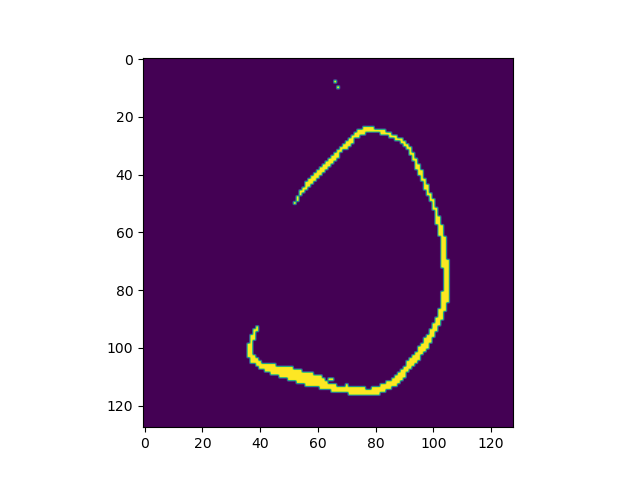

In [73]:
%%time
# threshold to take eels
threhold_eels = edges_detected.mean()*8
spots = edges_detected.copy()
spots[spots<threhold_eels]=0
spots[spots>0]= 1.0
print(spots.sum())
plt.figure()
plt.imshow(spots)

In [74]:
%%time
tstart = time.time()
image_size = 128# bad idea to hardcode this
array_server.activate_camera()
scale = int(2**14/image_size)
line_p = np.zeros([image_size, image_size, array.shape[0]])

accepted = 0
for i, y in enumerate(range(image_size)):
    print("line scan ", y, )
    for j, x in enumerate(range(image_size)):
        if edges_detected[i,j]> threhold_eels: # condition to do eels
            accepted+=1
            array_server.set_beam_pos(x, y)
            array_server.acquire_camera(exposure=0.1)
            array_list, shape, dtype = array_server.get_eels()
            array = np.array(array_list, dtype=dtype).reshape(shape)
            np.savez(f"eels_nanowire{x}_{y}.npz", spec = array)
            plt.plot(array)
            line_p[i,j] = array  # summing eels to get brigh field pixel value
tend = time.time()

line scan  0
line scan  1
line scan  2
line scan  3
line scan  4
line scan  5
line scan  6
line scan  7
line scan  8
line scan  9
line scan  10
line scan  11
line scan  12
line scan  13
line scan  14
line scan  15
line scan  16
line scan  17
line scan  18
line scan  19
line scan  20
line scan  21
line scan  22
line scan  23
line scan  24
line scan  25
line scan  26
line scan  27
line scan  28
line scan  29
line scan  30
line scan  31
line scan  32
line scan  33
line scan  34
line scan  35
line scan  36
line scan  37
line scan  38
line scan  39
line scan  40
line scan  41
line scan  42
line scan  43
line scan  44
line scan  45
line scan  46
line scan  47
line scan  48
line scan  49
line scan  50
line scan  51
line scan  52
line scan  53
line scan  54
line scan  55
line scan  56
line scan  57
line scan  58
line scan  59
line scan  60
line scan  61
line scan  62
line scan  63
line scan  64
line scan  65
line scan  66
line scan  67
line scan  68
line scan  69
line scan  70
line scan  71
li

In [75]:
print("accepted_points",accepted)
print("time_takenin seconds", tstart - tend)

accepted_points 466
time_takenin seconds -406.398827791214


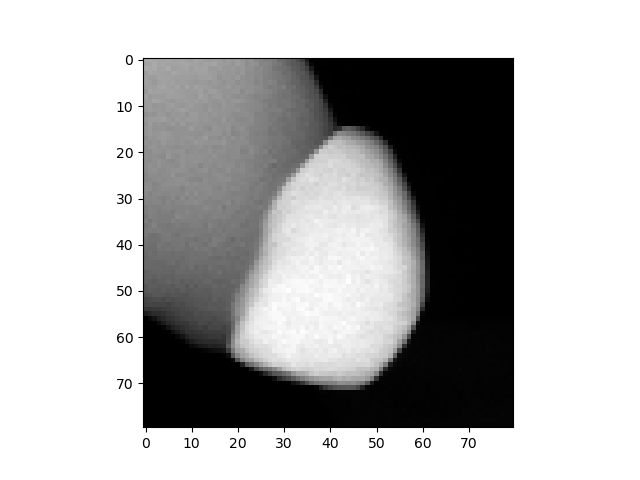

In [76]:
# get current positon to do eels
#Activate camera
array_server.activate_camera()
array_list, shape, dtype = array_server.get_ds(80)
im_array = np.array(array_list, dtype=dtype).reshape(shape)
plt.figure()
plt.imshow(im_array, cmap="gray")
plt.show()

CPU times: user 40.3 ms, sys: 0 ns, total: 40.3 ms
Wall time: 38 ms


Text(0.5, 1.0, 'eels image')

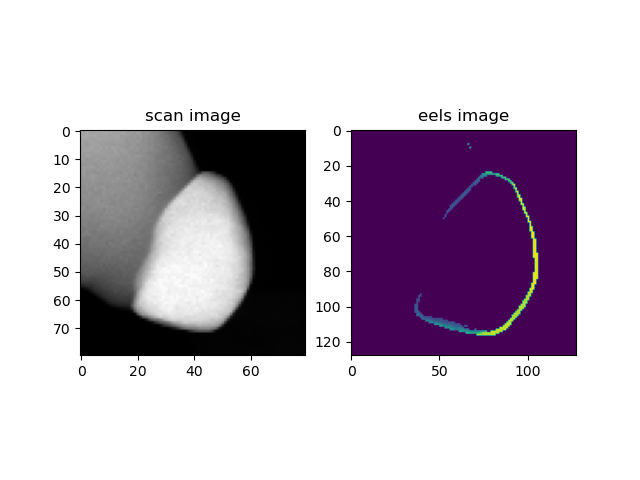

In [77]:
%%time
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(im_array, cmap="gray")
#ax1.axis('off')
ax1.set_title('scan image')
# line_p = line_p.max() -line_p
ax2.imshow(line_p.sum(axis=2))
#ax2.axis('off')
ax2.set_title('eels image')

In [ ]:
# now lets try doing eels at all places and compare

In [ ]:
tstart = time.time()
image_size = 10
array_server.activate_camera()
scale = int(2**14/image_size)
line_p = np.zeros([image_size, image_size, array.shape[0]])

accepted = 0
for i, x in enumerate(range(-int(image_size/2), int(image_size/2))):
    print("line scan ", x, 'at ', x*scale)
    for j, y in enumerate(range(-int(image_size/2), int(image_size/2))):
            accepted+=1
            array_server.set_beam_pos(x*scale, y*scale)
            array_server.acquire_camera()
            array_list, shape, dtype = array_server.get_eels()
            array = np.array(array_list, dtype=dtype).reshape(shape)
            #plt.plot(array)
            line_p[i,j] = array  # summing eels to get brigh field pixel value
tend = time.time()

In [ ]:
print("accepted_points",accepted)
print("time_takenin seconds", tstart - tend)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(im_array.T, cmap="gray")
#ax1.axis('off')
ax1.set_title('scan image')
#line_p = line_p.max() -line_p
ax2.imshow(line_p[:,:,:220].sum(axis=2))
#ax2.axis('off')
ax2.set_title('eels image')

In [ ]:
plt.plot(line_p[9,6,220:])